In [1003]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [1004]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [1005]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2214813 entries, 0 to 2214812
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 33.8 MB


# reduce to 1 million events

In [1006]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion Interval -> kWh

In [1007]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,19143,0.19,19.143
1,23524,0.15,23.524
2,27596,0.13,27.596
3,29495,0.12,29.495
4,28208,0.13,28.208
...,...,...,...
999995,28382,0.13,28.382
999996,28059,0.13,28.059
999997,27984,0.13,27.984
999998,27036,0.13,27.036


In [1008]:
conso_data['Wh']=3600000/conso_data['Interval']


### Cumul Total interval

In [1009]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [1010]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

25981449377000

### Calcul de la date de base = now - cumul_interval

In [1011]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 7, 17, 16, 6, 5, 134408)

In [1012]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [1013]:
conso_data.iloc[0]


Interval     19143.000000
kWh              0.190000
sec             19.143000
Wh             188.058298
cumul(ms)    19143.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [1014]:
base

datetime.datetime(2024, 7, 17, 16, 6, 5, 134408)

## créer les dates

In [1015]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-07-17 16:06:24.277408
1        2024-07-17 16:06:47.801408
2        2024-07-17 16:07:15.397408
3        2024-07-17 16:07:44.892408
4        2024-07-17 16:08:13.100408
                    ...            
999995   2025-05-14 09:08:24.140408
999996   2025-05-14 09:08:52.199408
999997   2025-05-14 09:09:20.183408
999998   2025-05-14 09:09:47.219408
999999   2025-05-14 09:10:14.511408
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [1016]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,19143,0.19,19.143,188.058298,19143,2024-07-17 16:06:24.277408,17/07/24
1,23524,0.15,23.524,153.035198,42667,2024-07-17 16:06:47.801408,17/07/24
2,27596,0.13,27.596,130.453689,70263,2024-07-17 16:07:15.397408,17/07/24
3,29495,0.12,29.495,122.054586,99758,2024-07-17 16:07:44.892408,17/07/24
4,28208,0.13,28.208,127.623369,127966,2024-07-17 16:08:13.100408,17/07/24
...,...,...,...,...,...,...,...
999995,28382,0.13,28.382,126.840956,25981339006,2025-05-14 09:08:24.140408,14/05/25
999996,28059,0.13,28.059,128.301080,25981367065,2025-05-14 09:08:52.199408,14/05/25
999997,27984,0.13,27.984,128.644940,25981395049,2025-05-14 09:09:20.183408,14/05/25
999998,27036,0.13,27.036,133.155792,25981422085,2025-05-14 09:09:47.219408,14/05/25


### save conso_data with dates

In [1017]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [1018]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
here = now.strftime('%H:%M:%S')
today, date, month, year, here

('14/05/25', 14, 5, 2025, '09:10:35')

In [1019]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [1020]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 986 entries, 999014 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   986 non-null    int64         
 1   kWh        986 non-null    float64       
 2   sec        986 non-null    float64       
 3   Wh         986 non-null    float64       
 4   cumul(ms)  986 non-null    int64         
 5   dates      986 non-null    datetime64[ns]
 6   days       986 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 61.6+ KB


In [1021]:
end = time.time()
print(end - start)

29.796088695526123


### grouped by days

In [1022]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [1023]:
data = list(df_grp['kWh'])
print(data)

[1.366, 3.28, 3.486, 3.276, 3.719, 3.561, 3.698, 3.596, 3.432, 3.258, 3.185, 2.852, 3.048, 3.447, 3.963, 3.859, 3.0, 3.322, 3.349, 3.511, 3.65, 3.496, 3.666, 3.793, 3.868, 3.661, 4.369, 4.309, 3.904, 3.886, 4.04, 3.795, 3.845, 3.706, 3.292, 3.919, 3.949, 4.444, 3.777, 4.111, 3.797, 3.97, 3.769, 3.963, 3.66, 3.658, 3.499, 3.671, 3.509, 4.141, 3.715, 3.449, 3.549, 3.234, 2.456, 1.795, 1.792, 1.794, 1.796, 2.479, 1.859, 1.787, 1.791, 1.791, 1.82, 1.822, 1.815, 1.817, 1.818, 1.818, 1.815, 1.814, 1.785, 1.786, 1.785, 1.787, 1.782, 1.797, 1.788, 1.79, 1.785, 1.795, 1.803, 1.795, 1.803, 1.796, 1.785, 1.79, 1.785, 1.79, 1.797, 1.791, 1.801, 1.803, 1.795, 1.8, 1.798, 2.789, 3.997, 3.65, 3.92, 3.089, 3.578, 4.019, 3.444, 3.372, 3.967, 3.342, 4.168, 3.082, 4.037, 3.149, 3.353, 3.482, 4.005, 3.293, 3.369, 3.824, 3.226, 3.538, 3.356, 3.87, 3.404, 3.701, 3.374, 4.468, 3.661, 3.828, 3.465, 4.099, 3.488, 3.418, 3.502, 3.676, 3.734, 4.057, 3.548, 3.473, 3.692, 3.154, 3.697, 3.754, 3.32, 3.836, 3.271, 4

In [1024]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [1025]:
end = time.time()
print(end - start)

30.730592489242554


### plot function by day
#### show('dd/mm/yy')

In [1026]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


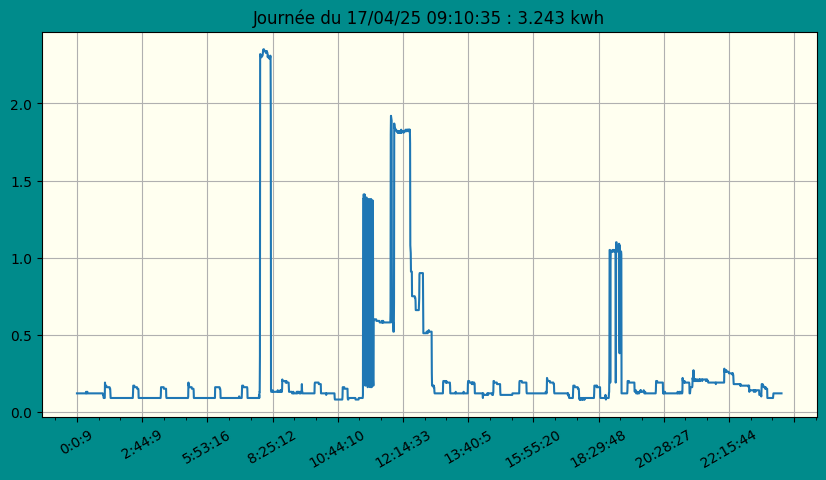

In [1027]:
show('17/04/25')

In [1028]:
end = time.time()
print(end - start)

33.81817436218262


### 1 kWh window in data of one day
#### df = conso_day

In [1029]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
999014,17772,0.20,17.772,202.565834,25948444136,2025-05-14 00:00:09.270408,14/05/25
999015,18181,0.20,18.181,198.008910,25948462317,2025-05-14 00:00:27.451408,14/05/25
999016,18273,0.20,18.273,197.011985,25948480590,2025-05-14 00:00:45.724408,14/05/25
999017,17669,0.20,17.669,203.746675,25948498259,2025-05-14 00:01:03.393408,14/05/25
999018,17777,0.20,17.777,202.508860,25948516036,2025-05-14 00:01:21.170408,14/05/25
...,...,...,...,...,...,...,...
999995,28382,0.13,28.382,126.840956,25981339006,2025-05-14 09:08:24.140408,14/05/25
999996,28059,0.13,28.059,128.301080,25981367065,2025-05-14 09:08:52.199408,14/05/25
999997,27984,0.13,27.984,128.644940,25981395049,2025-05-14 09:09:20.183408,14/05/25
999998,27036,0.13,27.036,133.155792,25981422085,2025-05-14 09:09:47.219408,14/05/25


In [1030]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [1031]:
df = conso_day
len(df)

986

In [1032]:
period()  # first kWh
if len(df)>1000:
    period(p=2) # second period

2025-05-14 00:00:09.270408	2025-05-14 09:10:14.511408	9h 10m 5s 	986


In [1033]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.300453
dtype: float64

In [1034]:
end = time.time()
print(end - start)

35.80741739273071


## mean for data grouped by days

In [1035]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.311258
dtype: float64

In [1036]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(0.986)

# conso by date


In [1037]:
# select day
day = today

#day = '16/08/24'
day

'14/05/25'

In [1038]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
999014,17772,0.20,17.772,202.565834,25948444136,2025-05-14 00:00:09.270408,14/05/25
999015,18181,0.20,18.181,198.008910,25948462317,2025-05-14 00:00:27.451408,14/05/25
999016,18273,0.20,18.273,197.011985,25948480590,2025-05-14 00:00:45.724408,14/05/25
999017,17669,0.20,17.669,203.746675,25948498259,2025-05-14 00:01:03.393408,14/05/25
999018,17777,0.20,17.777,202.508860,25948516036,2025-05-14 00:01:21.170408,14/05/25
...,...,...,...,...,...,...,...
999995,28382,0.13,28.382,126.840956,25981339006,2025-05-14 09:08:24.140408,14/05/25
999996,28059,0.13,28.059,128.301080,25981367065,2025-05-14 09:08:52.199408,14/05/25
999997,27984,0.13,27.984,128.644940,25981395049,2025-05-14 09:09:20.183408,14/05/25
999998,27036,0.13,27.036,133.155792,25981422085,2025-05-14 09:09:47.219408,14/05/25


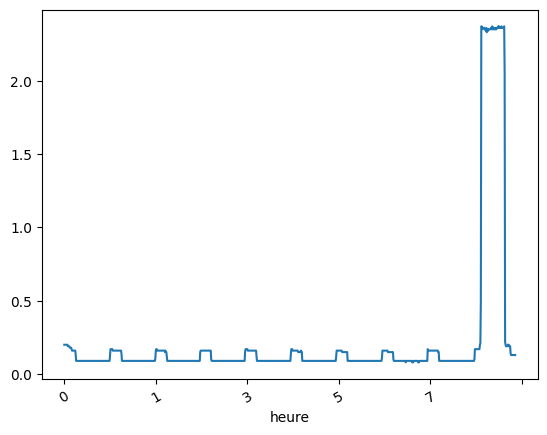

In [1039]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df3= conso_day.set_index('heure')
df3.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [1040]:
end = time.time()
print(end - start)

36.41324234008789


### grouped by 'heure'

In [1041]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 986 entries, 999014 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   986 non-null    int64         
 1   kWh        986 non-null    float64       
 2   sec        986 non-null    float64       
 3   Wh         986 non-null    float64       
 4   cumul(ms)  986 non-null    int64         
 5   dates      986 non-null    datetime64[ns]
 6   days       986 non-null    object        
 7   heure      986 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 69.3+ KB


In [1042]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
999014,17772,0.20,17.772,202.565834,25948444136,2025-05-14 00:00:09.270408,14/05/25
999015,18181,0.20,18.181,198.008910,25948462317,2025-05-14 00:00:27.451408,14/05/25
999016,18273,0.20,18.273,197.011985,25948480590,2025-05-14 00:00:45.724408,14/05/25
999017,17669,0.20,17.669,203.746675,25948498259,2025-05-14 00:01:03.393408,14/05/25
999018,17777,0.20,17.777,202.508860,25948516036,2025-05-14 00:01:21.170408,14/05/25
...,...,...,...,...,...,...,...
999995,28382,0.13,28.382,126.840956,25981339006,2025-05-14 09:08:24.140408,14/05/25
999996,28059,0.13,28.059,128.301080,25981367065,2025-05-14 09:08:52.199408,14/05/25
999997,27984,0.13,27.984,128.644940,25981395049,2025-05-14 09:09:20.183408,14/05/25
999998,27036,0.13,27.036,133.155792,25981422085,2025-05-14 09:09:47.219408,14/05/25


In [1043]:
# group by hour, df  = data of a chosen day
df_byhour = df3[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [1044]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0    108
1    102
2    102
3    102
4    101
5     99
6     99
7     96
8    100
9     77
Name: kWh, dtype: int64

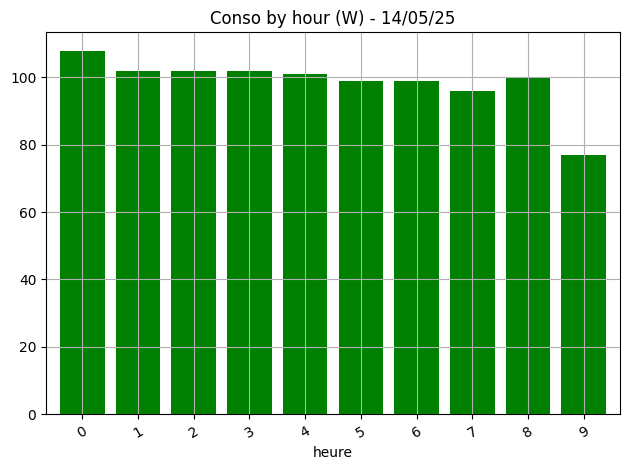

In [1045]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [1046]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 302 entries, 17/07/24 to 14/05/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     302 non-null    float64
dtypes: float64(1)
memory usage: 4.7+ KB


In [1047]:
# give the periods of 1 kwh in a day
period()

2025-05-14 00:00:09.270408	2025-05-14 09:10:14.511408	9h 10m 5s 	986


In [1048]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
    df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


In [1049]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [1050]:
df_grp.mean()


kWh    3.311258
dtype: float64

In [1051]:
df_grp.head()


,kWh
days,
17/07/24,1.366
18/07/24,3.280
19/07/24,3.486
20/07/24,3.276
21/07/24,3.719


In [1052]:
df_grp.tail()


,kWh
days,
10/05/25,2.609
11/05/25,2.624
12/05/25,2.744
13/05/25,3.145
14/05/25,0.986


In [1053]:
end = time.time()
print(end - start)

37.60728359222412


# plot les 100 derniers jours


In [1054]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.42836
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

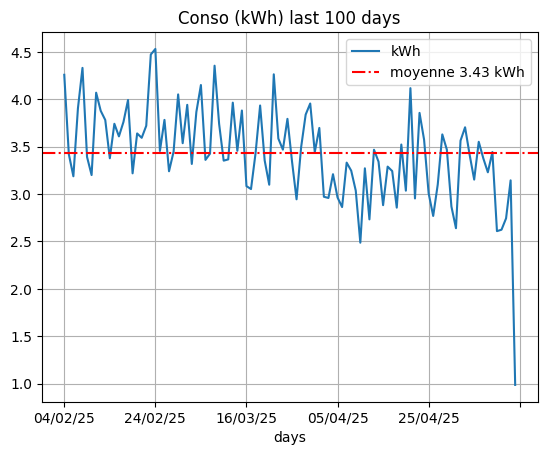

In [1055]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.axhline(y=np.nanmean(df_100),c='red', ls='-.',label=f'moyenne {np.nanmean(df_100):.2f} kWh')
plt.grid()
plt.legend()
plt.title('Conso (kWh) last 100 days')


In [1056]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,0.986
max,4.532


In [1057]:
end = time.time()
print(end - start)

38.18034863471985


In [1058]:
df_grp[-31:-1].index[0],df_grp[-31:-1].index[-5]

('14/04/25', '09/05/25')

In [1059]:
moyenne = df_grp.iloc[-31:-1].mean()
moyenne

kWh    3.2242
dtype: float64

Text(0.5, 1.0, 'Last month conso by day')

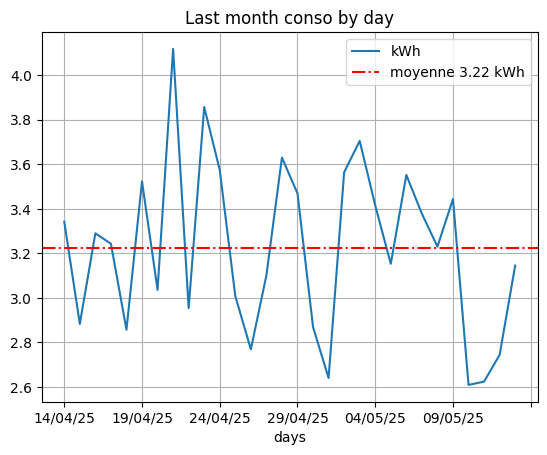

In [1060]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.axhline(y=np.nanmean(df_grp.iloc[-31:-1]),c='red', ls='-.',label=f'moyenne {np.nanmean(df_grp.iloc[-31:-1]):.2f} kWh')  
plt.legend()
plt.grid()
plt.title('Last month conso by day')


In [1061]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 21/04/25 4.118
Min : 10/05/25 2.609


# Temps de conso par tranche de 1 kWh

In [1062]:
def show_tranches():    # temps de conso par tranches de 1kwh
    tranches = len(df)//1000
    print(tranches+1)
    for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
        if len(df)>(p-1)*1000:
            period(p=p)

show_tranches()


1
2025-05-14 00:00:09.270408	2025-05-14 09:10:14.511408	9h 10m 5s 	986


In [1063]:
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


('09:10:35', 0.986, 986)

In [1064]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 986 entries, 999014 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   986 non-null    int64         
 1   kWh        986 non-null    float64       
 2   sec        986 non-null    float64       
 3   Wh         986 non-null    float64       
 4   cumul(ms)  986 non-null    int64         
 5   dates      986 non-null    datetime64[ns]
 6   days       986 non-null    object        
 7   heure      986 non-null    object        
 8   hours      986 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 77.0+ KB


In [1065]:
conso_hours['heure'], conso_hours['hours']

(999014    0
 999015    0
 999016    0
 999017    0
 999018    0
          ..
 999995    9
 999996    9
 999997    9
 999998    9
 999999    9
 Name: heure, Length: 986, dtype: object,
 999014    00
 999015    00
 999016    00
 999017    00
 999018    00
           ..
 999995    09
 999996    09
 999997    09
 999998    09
 999999    09
 Name: hours, Length: 986, dtype: object)

In [1066]:
end = time.time()
print(end - start)

39.03372859954834


# select number of days to display


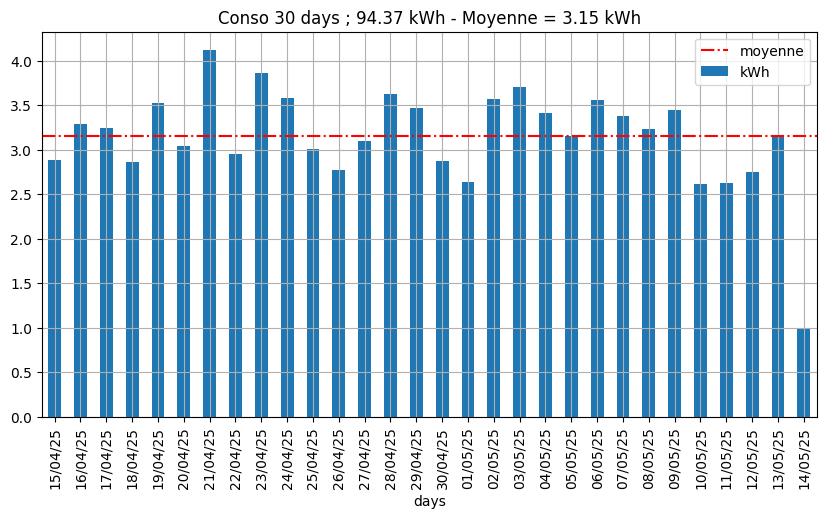

In [1067]:
span = 30
conso_mois = round(df_grp.tail(span)['kWh'].sum(),2)

# Plot the figure without labels
moy = round(np.nanmean(df_grp.tail(span)),2)
#conso_mois = sum(df_grp.tail(span)['kWh'])
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight')
 
plt.title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
plt.xticks(rotation=90);


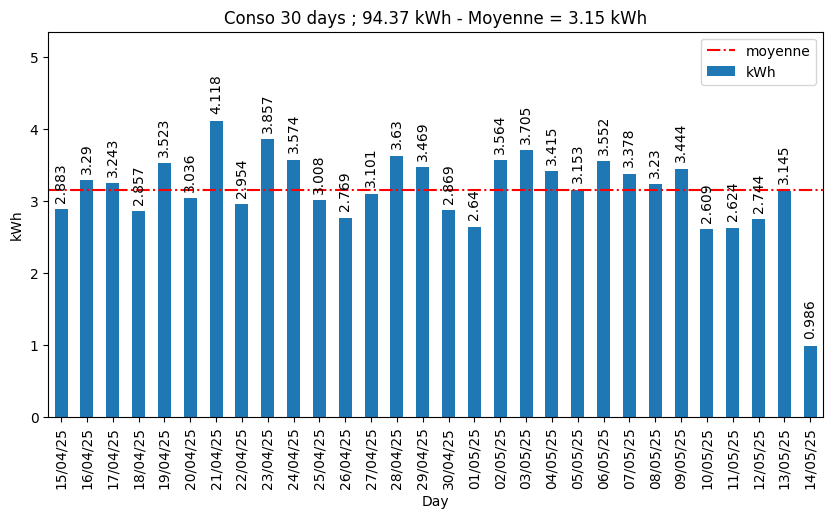

In [1068]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
#ax.set_title(f"Conso by {span} days")
ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [1069]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
15/04/25    2.883
16/04/25    3.290
17/04/25    3.243
18/04/25    2.857
19/04/25    3.523
20/04/25    3.036
21/04/25    4.118
22/04/25    2.954
23/04/25    3.857
24/04/25    3.574
25/04/25    3.008
26/04/25    2.769
27/04/25    3.101
28/04/25    3.630
29/04/25    3.469
30/04/25    2.869
01/05/25    2.640
02/05/25    3.564
03/05/25    3.705
04/05/25    3.415
05/05/25    3.153
06/05/25    3.552
07/05/25    3.378
08/05/25    3.230
09/05/25    3.444
10/05/25    2.609
11/05/25    2.624
12/05/25    2.744
13/05/25    3.145
14/05/25    0.986
Name: kWh, dtype: float64

In [1070]:
x_labels=df_grp.tail(span).index
x_labels

Index(['15/04/25', '16/04/25', '17/04/25', '18/04/25', '19/04/25', '20/04/25',
       '21/04/25', '22/04/25', '23/04/25', '24/04/25', '25/04/25', '26/04/25',
       '27/04/25', '28/04/25', '29/04/25', '30/04/25', '01/05/25', '02/05/25',
       '03/05/25', '04/05/25', '05/05/25', '06/05/25', '07/05/25', '08/05/25',
       '09/05/25', '10/05/25', '11/05/25', '12/05/25', '13/05/25', '14/05/25'],
      dtype='object', name='days')

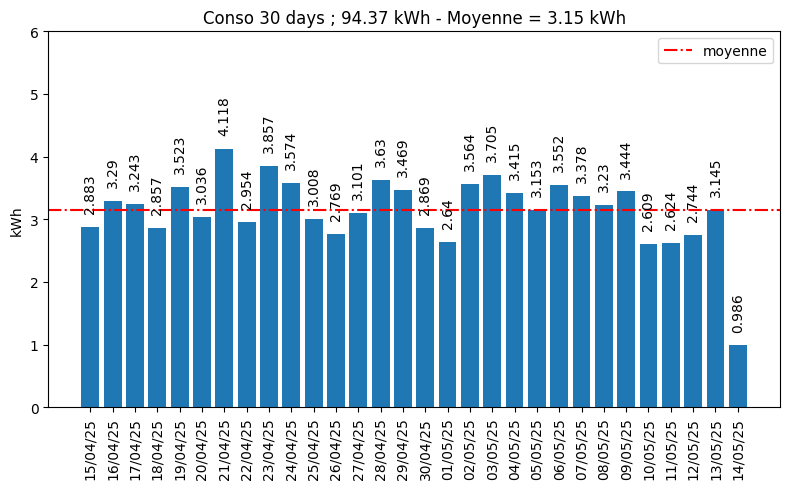

In [1071]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
#ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
ax.set(ylabel='kWh', title=f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh', ylim=(0, 6))
plt.xticks(rotation=90);


In [1072]:
end = time.time()
print(end - start)

43.553085803985596


In [1073]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

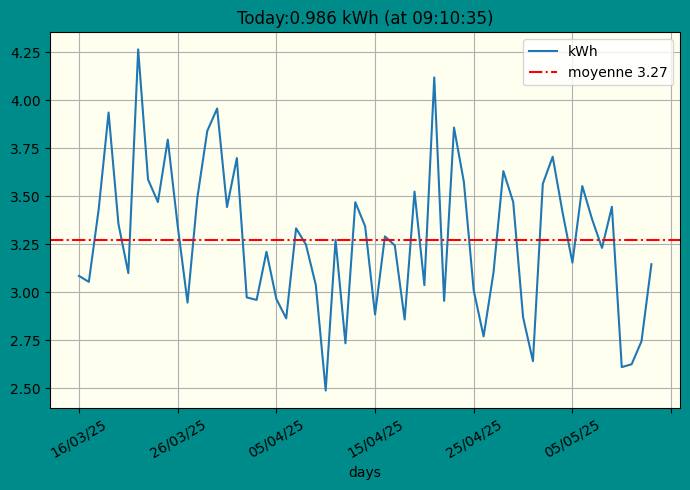

In [1074]:
# 2 last months
scan = 60
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

moy = round(np.nanmean(df_grp.iloc[-scan:-1]),2)
df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(f'Today:{last} kWh (at {here})')
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

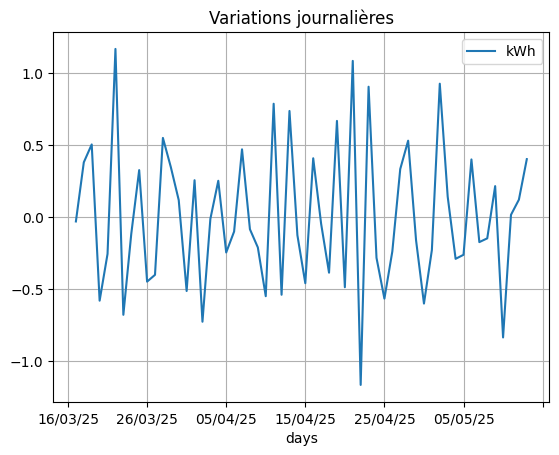

In [1075]:
# variations journalières sur 60 jours
df_grp.iloc[-60:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [1076]:
end = time.time()
print(end - start)

44.66871452331543


# Data from 21/08/23

In [1077]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,19143,0.19,19.143,188.058298,19143,2024-07-17 16:06:24.277408,17/07/24,16,2024-07,17
1,23524,0.15,23.524,153.035198,42667,2024-07-17 16:06:47.801408,17/07/24,16,2024-07,17
2,27596,0.13,27.596,130.453689,70263,2024-07-17 16:07:15.397408,17/07/24,16,2024-07,17
3,29495,0.12,29.495,122.054586,99758,2024-07-17 16:07:44.892408,17/07/24,16,2024-07,17
4,28208,0.13,28.208,127.623369,127966,2024-07-17 16:08:13.100408,17/07/24,16,2024-07,17
...,...,...,...,...,...,...,...,...,...,...
999995,28382,0.13,28.382,126.840956,25981339006,2025-05-14 09:08:24.140408,14/05/25,09,2025-05,14
999996,28059,0.13,28.059,128.301080,25981367065,2025-05-14 09:08:52.199408,14/05/25,09,2025-05,14
999997,27984,0.13,27.984,128.644940,25981395049,2025-05-14 09:09:20.183408,14/05/25,09,2025-05,14
999998,27036,0.13,27.036,133.155792,25981422085,2025-05-14 09:09:47.219408,14/05/25,09,2025-05,14


In [1078]:
end = time.time()
print(end - start)

83.94040608406067


In [1079]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05'])

# define month to show

Text(0.5, 1.0, 'Conso by day (W) (2025-04)')

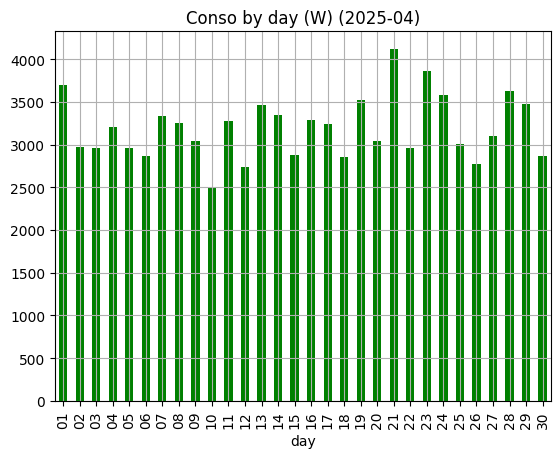

In [1080]:
m = '2025-04'
month=conso_grouped_by_month.get_group(m)
conso_grouped_by_month_day = month.groupby(['day'], sort=False)
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)
plt.title(f'Conso by day (W) ({m})')

In [1081]:
c=conso_grouped_by_month_day['hours'].count()
c.mean()


np.float64(3192.133333333333)

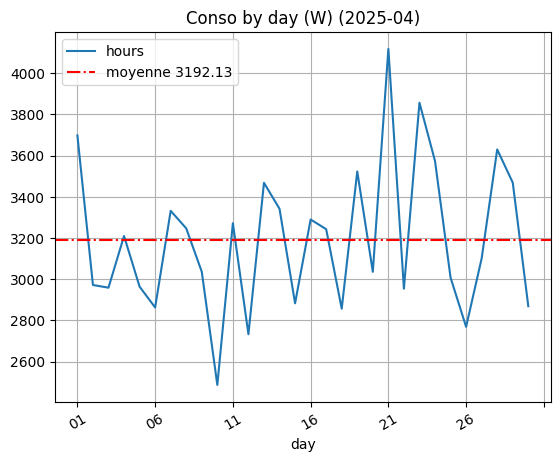

In [1082]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
moy = round(c.mean(),2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (W) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);


In [1083]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

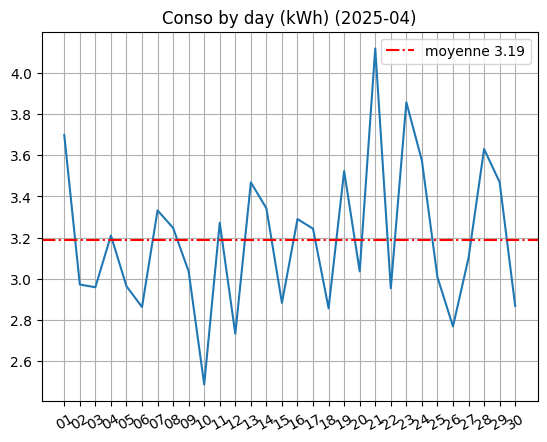

In [1084]:
plt.plot(conso_grouped_by_month_day['kWh'].count()/1000)
plt.grid()
moy = round(c.mean()/1000,2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (kWh) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);

In [1085]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [1086]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [1087]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-07,49167,49167,49167
2024-08,117338,117338,117338
2024-09,69789,69789,69789
2024-10,73494,73494,73494
2024-11,108517,108517,108517
2024-12,113740,113740,113740
2025-01,113654,113654,113654
2025-02,104483,104483,104483
2025-03,111865,111865,111865


In [1088]:
# example groupby with apply
df2 = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df2.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [1089]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [1090]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
17/07/24,1366
18/07/24,3280
19/07/24,3486
20/07/24,3276
21/07/24,3719
...,...
10/05/25,2609
11/05/25,2624
12/05/25,2744


In [1091]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,19143,0.19,19.143,188.058298,19143,2024-07-17 16:06:24.277408,17/07/24,16,2024-07,17
1,23524,0.15,23.524,153.035198,42667,2024-07-17 16:06:47.801408,17/07/24,16,2024-07,17
2,27596,0.13,27.596,130.453689,70263,2024-07-17 16:07:15.397408,17/07/24,16,2024-07,17
3,29495,0.12,29.495,122.054586,99758,2024-07-17 16:07:44.892408,17/07/24,16,2024-07,17
4,28208,0.13,28.208,127.623369,127966,2024-07-17 16:08:13.100408,17/07/24,16,2024-07,17
...,...,...,...,...,...,...,...,...,...,...
999995,28382,0.13,28.382,126.840956,25981339006,2025-05-14 09:08:24.140408,14/05/25,09,2025-05,14
999996,28059,0.13,28.059,128.301080,25981367065,2025-05-14 09:08:52.199408,14/05/25,09,2025-05,14
999997,27984,0.13,27.984,128.644940,25981395049,2025-05-14 09:09:20.183408,14/05/25,09,2025-05,14
999998,27036,0.13,27.036,133.155792,25981422085,2025-05-14 09:09:47.219408,14/05/25,09,2025-05,14


In [1092]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
17/07/24 16    0       17/07/24    16  0.19
               1       17/07/24    16  0.15
               2       17/07/24    16  0.13
               3       17/07/24    16  0.12
               4       17/07/24    16  0.13
...                         ...   ...   ...
14/05/25 09    999995  14/05/25    09  0.13
               999996  14/05/25    09  0.13
               999997  14/05/25    09  0.13
               999998  14/05/25    09  0.13
               999999  14/05/25    09  0.13

[1000000 rows x 3 columns]

In [1093]:
groupallbyday.indices.keys()

dict_keys(['17/07/24', '18/07/24', '19/07/24', '20/07/24', '21/07/24', '22/07/24', '23/07/24', '24/07/24', '25/07/24', '26/07/24', '27/07/24', '28/07/24', '29/07/24', '30/07/24', '31/07/24', '01/08/24', '02/08/24', '03/08/24', '04/08/24', '05/08/24', '06/08/24', '07/08/24', '08/08/24', '09/08/24', '10/08/24', '11/08/24', '12/08/24', '13/08/24', '14/08/24', '15/08/24', '16/08/24', '17/08/24', '18/08/24', '19/08/24', '20/08/24', '21/08/24', '22/08/24', '23/08/24', '24/08/24', '25/08/24', '26/08/24', '27/08/24', '28/08/24', '29/08/24', '30/08/24', '31/08/24', '01/09/24', '02/09/24', '03/09/24', '04/09/24', '05/09/24', '06/09/24', '07/09/24', '08/09/24', '09/09/24', '10/09/24', '11/09/24', '12/09/24', '13/09/24', '14/09/24', '15/09/24', '16/09/24', '17/09/24', '18/09/24', '19/09/24', '20/09/24', '21/09/24', '22/09/24', '23/09/24', '24/09/24', '25/09/24', '26/09/24', '27/09/24', '28/09/24', '29/09/24', '30/09/24', '01/10/24', '02/10/24', '03/10/24', '04/10/24', '05/10/24', '06/10/24', '07/1

In [1094]:
groupallbydayhours.indices.keys()

dict_keys([('17/07/24', '16'), ('17/07/24', '17'), ('17/07/24', '18'), ('17/07/24', '19'), ('17/07/24', '20'), ('17/07/24', '21'), ('17/07/24', '22'), ('17/07/24', '23'), ('18/07/24', '16'), ('18/07/24', '17'), ('18/07/24', '18'), ('18/07/24', '19'), ('18/07/24', '20'), ('18/07/24', '21'), ('18/07/24', '22'), ('18/07/24', '23'), ('18/07/24', '00'), ('18/07/24', '01'), ('18/07/24', '02'), ('18/07/24', '03'), ('18/07/24', '04'), ('18/07/24', '05'), ('18/07/24', '06'), ('18/07/24', '07'), ('18/07/24', '08'), ('18/07/24', '09'), ('18/07/24', '10'), ('18/07/24', '11'), ('18/07/24', '12'), ('18/07/24', '13'), ('18/07/24', '14'), ('18/07/24', '15'), ('19/07/24', '16'), ('19/07/24', '17'), ('19/07/24', '18'), ('19/07/24', '19'), ('19/07/24', '20'), ('19/07/24', '21'), ('19/07/24', '22'), ('19/07/24', '23'), ('19/07/24', '00'), ('19/07/24', '01'), ('19/07/24', '02'), ('19/07/24', '03'), ('19/07/24', '04'), ('19/07/24', '05'), ('19/07/24', '06'), ('19/07/24', '07'), ('19/07/24', '08'), ('19/07/2

In [1095]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
17/07/24,1366,1366
18/07/24,3280,3280
19/07/24,3486,3486
20/07/24,3276,3276
21/07/24,3719,3719
...,...,...
10/05/25,2609,2609
11/05/25,2624,2624
12/05/25,2744,2744


In [1096]:
grp_by_day['kWh'].cumsum()

days
17/07/24       1366
18/07/24       4646
19/07/24       8132
20/07/24      11408
21/07/24      15127
             ...   
10/05/25     990501
11/05/25     993125
12/05/25     995869
13/05/25     999014
14/05/25    1000000
Name: kWh, Length: 302, dtype: int64

In [1097]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
17/07/24 16     264
         17     123
         18     119
         19     124
         20     117
...             ...
14/05/25 05      99
         06      99
         07      96
         08     100
         09      77

[7218 rows x 1 columns]

In [1098]:
grp_by_dayhours['kWh'].cumsum()

days      hours
17/07/24  16           264
          17           387
          18           506
          19           630
          20           747
                    ...   
14/05/25  05        999628
          06        999727
          07        999823
          08        999923
          09       1000000
Name: kWh, Length: 7218, dtype: int64

In [1099]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
17/07/24 16     264     264    NaN
         17     123     387 -141.0
         18     119     506   -4.0
         19     124     630    5.0
         20     117     747   -7.0
...             ...     ...    ...
14/05/25 05      99     614   -2.0
         06      99     713    0.0
         07      96     809   -3.0
         08     100     909    4.0
         09      77     986  -23.0

[7218 rows x 3 columns]

In [1100]:
today, grp_by_dayhours.loc[today]

('14/05/25',
        kWh  cumsum  diff
 hours                   
 00     108     108   NaN
 01     102     210  -6.0
 02     102     312   0.0
 03     102     414   0.0
 04     101     515  -1.0
 05      99     614  -2.0
 06      99     713   0.0
 07      96     809  -3.0
 08     100     909   4.0
 09      77     986 -23.0)

Text(0.5, 1.0, 'Cumul journalier')

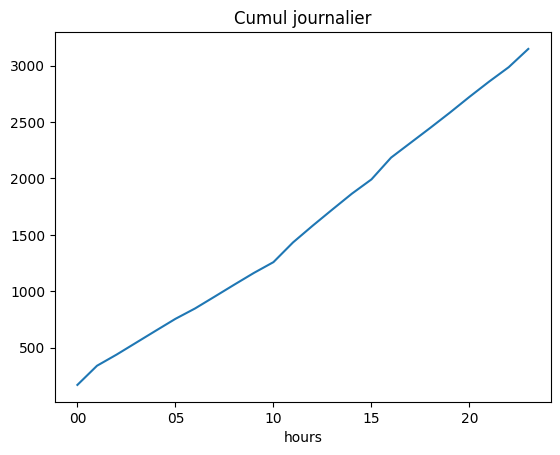

In [1101]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

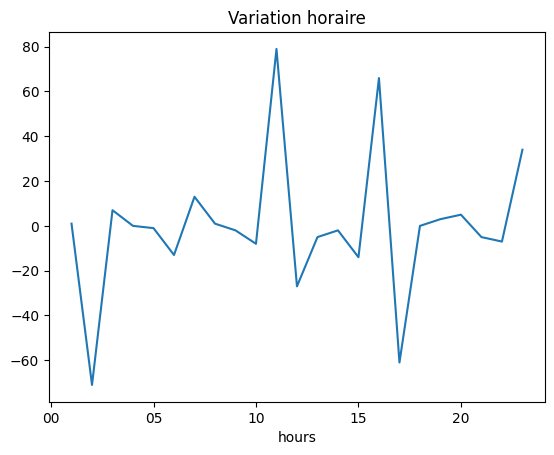

In [1102]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [1103]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

302

In [1104]:
df_grp.tail(n)['kWh'].describe()


count    302.000000
mean       3.311258
std        0.745076
min        0.986000
25%        3.102500
50%        3.448000
75%        3.781000
max        4.809000
Name: kWh, dtype: float64

In [1105]:
maxday = df_grp.tail(n)['kWh'].idxmax()

In [1106]:
n, np.nanmean(df_grp.tail(n))

(302, np.float64(3.3112582781456954))

Text(0.5, 1.0, '302 days')

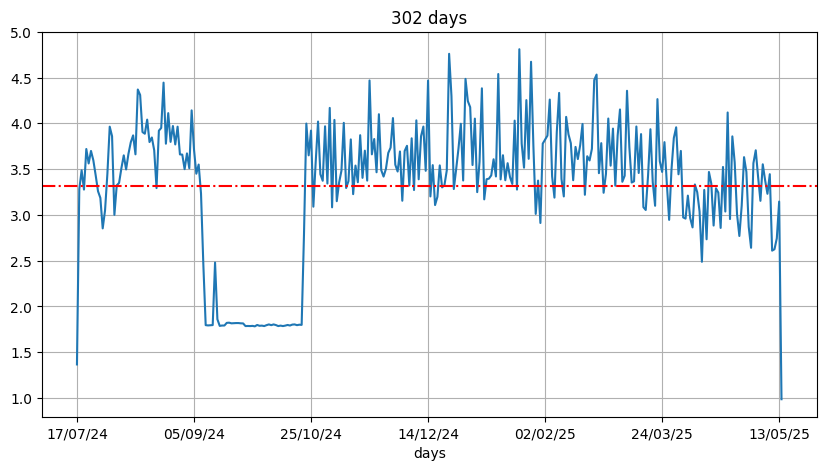

In [1107]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

Text(0.5, 1.0, '100 days')

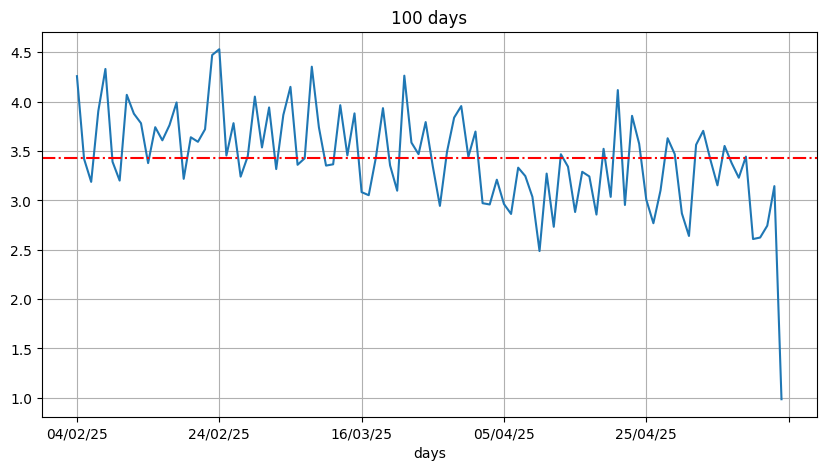

In [1108]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

In [1109]:
np.nanmean(df_grp.tail(span))

np.float64(3.42836)

In [1110]:
df_grp['kWh']

days
17/07/24    1.366
18/07/24    3.280
19/07/24    3.486
20/07/24    3.276
21/07/24    3.719
            ...  
10/05/25    2.609
11/05/25    2.624
12/05/25    2.744
13/05/25    3.145
14/05/25    0.986
Name: kWh, Length: 302, dtype: float64

In [1111]:
df_grp.describe()

,kWh
count,302.000000
mean,3.311258
std,0.745076
min,0.986000
25%,3.102500
50%,3.448000
75%,3.781000
max,4.809000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

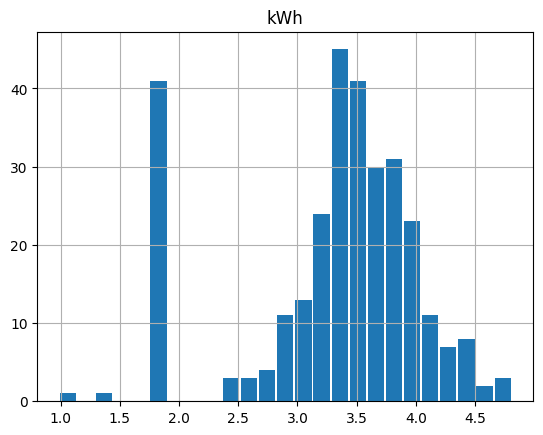

In [1112]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [1113]:
df_grp.tail(span)['kWh']

days
04/02/25    4.259
05/02/25    3.421
06/02/25    3.188
07/02/25    3.905
08/02/25    4.332
            ...  
10/05/25    2.609
11/05/25    2.624
12/05/25    2.744
13/05/25    3.145
14/05/25    0.986
Name: kWh, Length: 100, dtype: float64

# Conso par heure

In [1114]:
day

'14/05/25'

In [1115]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,108,108,NaN
01,102,210,-6.0
02,102,312,0.0
03,102,414,0.0
04,101,515,-1.0
05,99,614,-2.0
06,99,713,0.0
07,96,809,-3.0
08,100,909,4.0


In [1116]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


10

In [1117]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 11)

In [1118]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [1119]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [1120]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
Name: days, dtype: float64

In [1121]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [1122]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 00 to 09
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     10 non-null     int64  
 1   cumsum  10 non-null     int64  
 2   diff    9 non-null      float64
 3   days    10 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 400.0+ bytes


In [1123]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
Name: days, dtype: float64

In [1124]:
day

'14/05/25'

In [1125]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,108,108,NaN,1.0
01,102,210,-6.0,2.0
02,102,312,0.0,3.0
03,102,414,0.0,4.0
04,101,515,-1.0,5.0
05,99,614,-2.0,6.0
06,99,713,0.0,7.0
07,96,809,-3.0,8.0
08,100,909,4.0,9.0


In [1126]:
kwh = grp_by_dayhours.loc[day][['kWh']]
np.sum(kwh)[0]


c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\jeand\AppData\Local\Temp\ipykernel_1892\3891495459.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.sum(kwh)[0]


np.int64(986)

c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, '14/05/25: kWh    986\ndtype: int64')

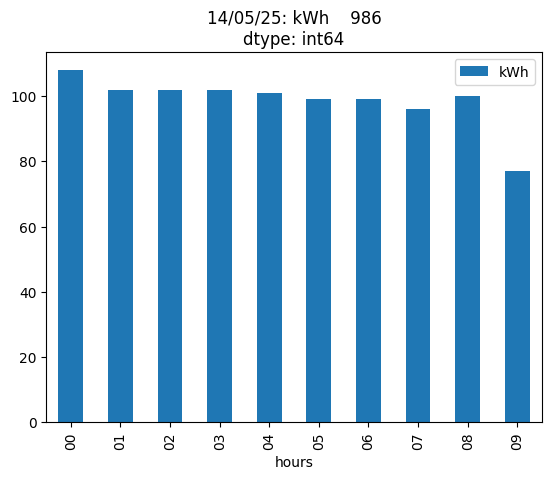

In [1127]:
kwh.plot.bar()
plt.title(f'{day}: {np.sum(kwh)}')

In [1128]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09'], dtype='object', name='hours')

# Conso du jour


In [1129]:

grp_by_dayhours.count()

kWh       7218
cumsum    7218
diff      6916
days        10
dtype: int64

'22/01/25'

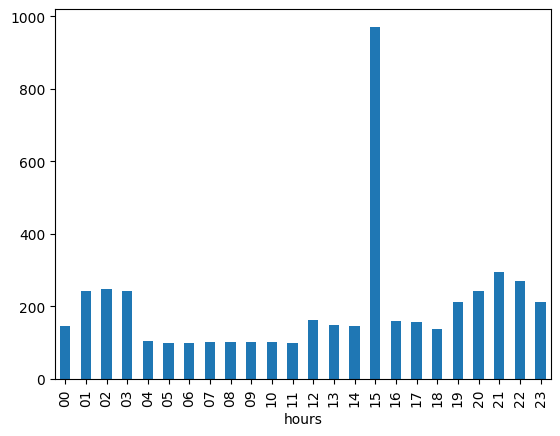

In [1130]:
#day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh.plot(kind='bar')
maxday

In [1131]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

In [1132]:
df_grp.tail(7)['kWh']

days
08/05/25    3.230
09/05/25    3.444
10/05/25    2.609
11/05/25    2.624
12/05/25    2.744
13/05/25    3.145
14/05/25    0.986
Name: kWh, dtype: float64

Total= 342.836 , Moyenne= 3.42836


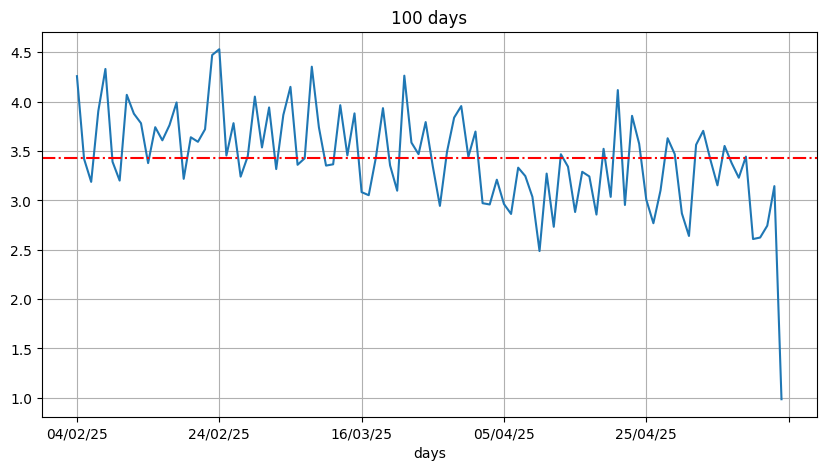

In [1133]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

print('Total=',sum(df_grp.tail(span)['kWh']),', Moyenne=',np.nanmean(df_grp.tail(span)))

In [1134]:
from datetime import datetime

# Get the current time
current_time = datetime.now()

# Convert the time to minutes in a day
minutes_in_day = current_time.hour * 60 + current_time.minute
print(f"Current time: {current_time.strftime('%H:%M:%S')}, Minutes in day: {minutes_in_day}")

Current time: 09:11:47, Minutes in day: 551


In [1135]:
def convert_to_min_sec(seconds):
    """
    Convert a float value in seconds to minutes and seconds.
    """
    minutes, sec = divmod(seconds, 60)
    return f'{int(minutes)}:{round(sec, 2)}'


In [1136]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(convert_to_min_sec(end - start))

1:38.09


In [1137]:
end - start

98.08690476417542

In [1138]:
#df = conso_day
show_tranches()

1
2025-05-14 00:00:09.270408	2025-05-14 09:10:14.511408	9h 10m 5s 	986


# Today

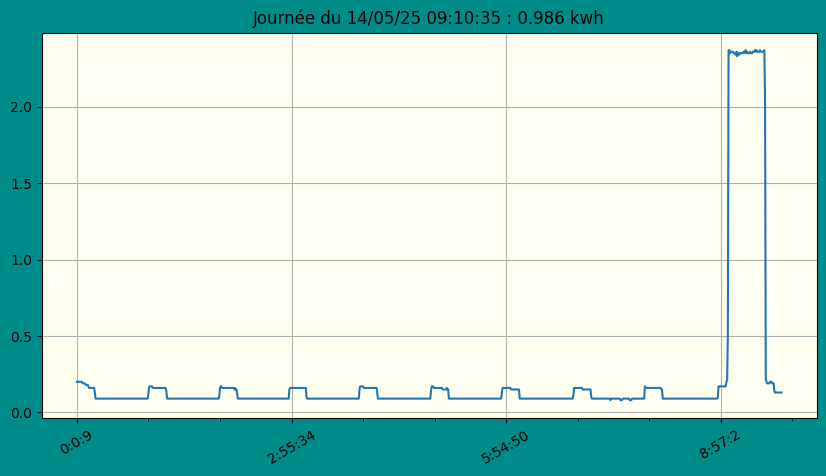

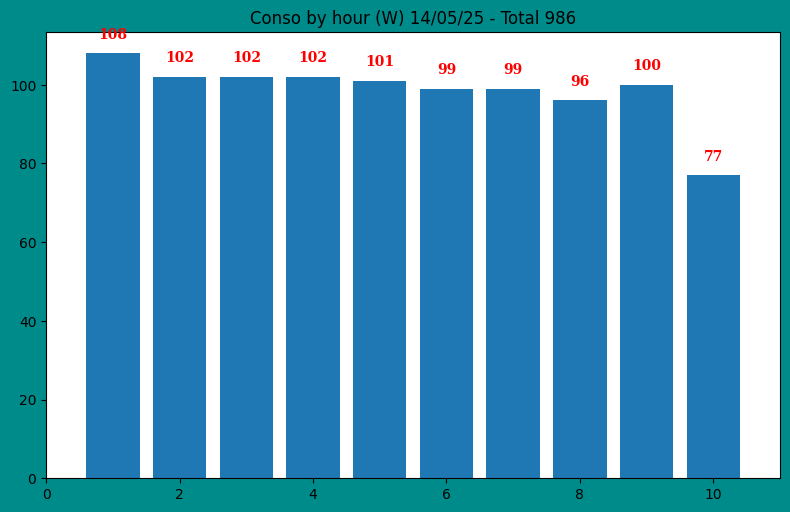

In [1139]:
show(today,bgcolor='ivory')
conso_by_hour(today)

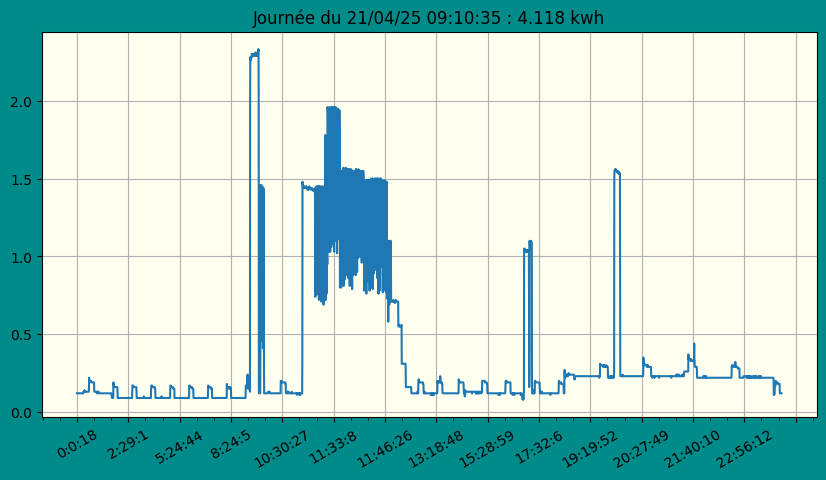

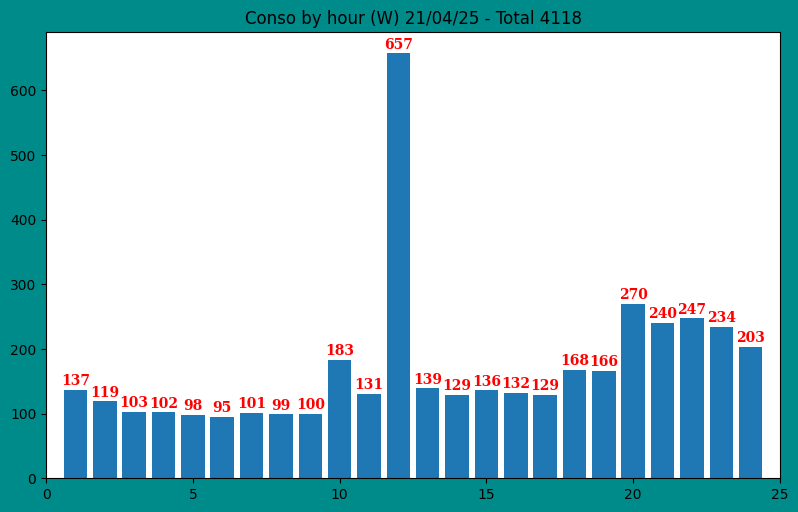

In [1140]:
day = '21/04/25' # 21/04/25 cuisine midi et télé le soir 4.115 kWh
day, show(day,bgcolor='ivory')
conso_by_hour(day)

22/01/25


(None, 4809)

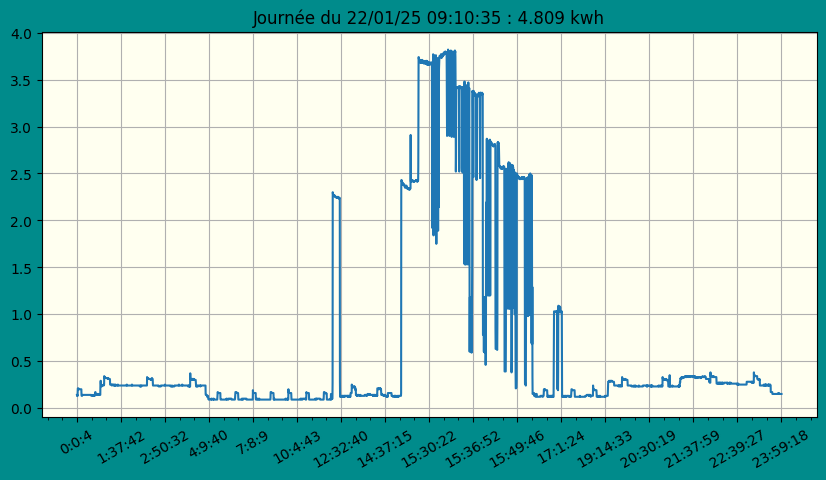

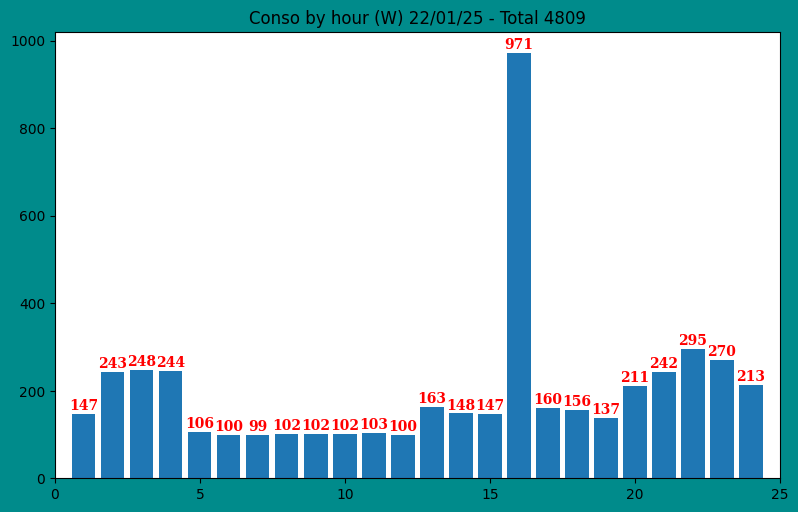

In [1141]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

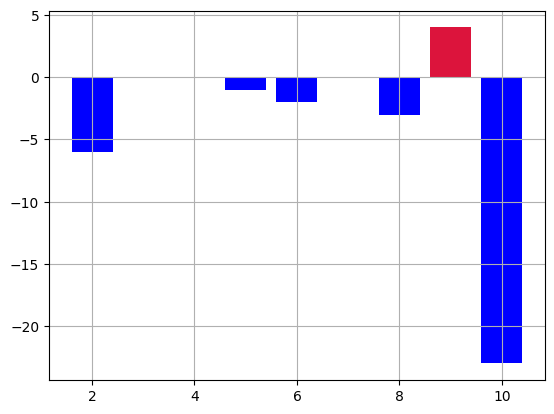

In [1142]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

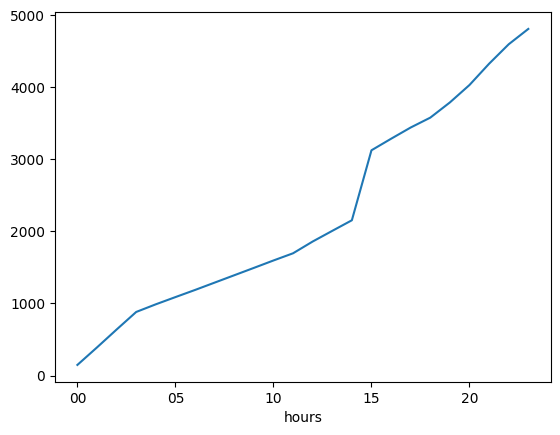

In [1143]:
data.cumsum().plot()


<Axes: xlabel='hours'>

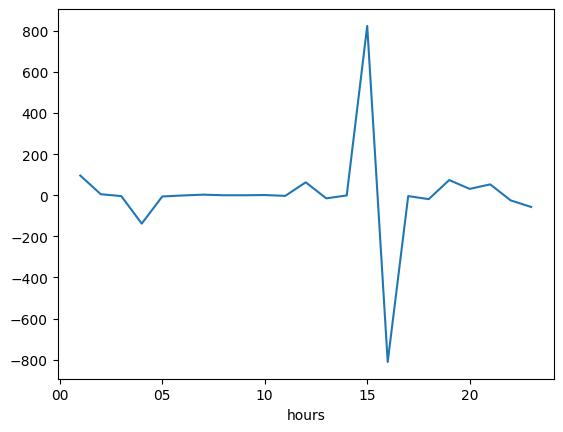

In [1144]:
# evolution par heure
data.diff().plot()

In [1145]:
data.diff().describe()

count     23.000000
mean       2.869565
std      250.686023
min     -811.000000
25%      -10.500000
50%       -1.000000
75%       18.000000
max      824.000000
Name: kWh, dtype: float64

<Axes: >

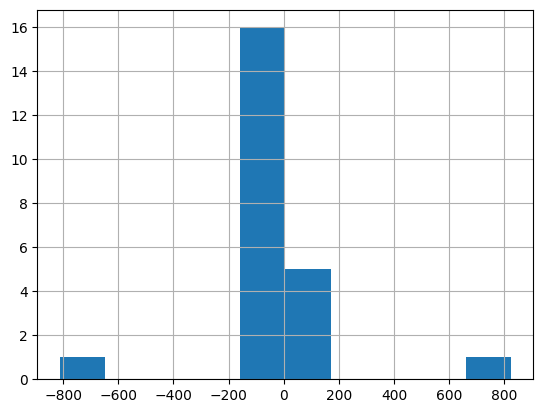

In [1146]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [1147]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'isp_simulation_falcon9.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_chap10.ipynb',
 'table-indicateurs-open-data-france-2023-06-30-17h59.csv',
 'primes12million.pkl',
 'espace_de_phase.ipynb',
 'ipinfo_test.ipynb',
 'enigma_setting

# list store files csv


In [1148]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('22/01/25', None)

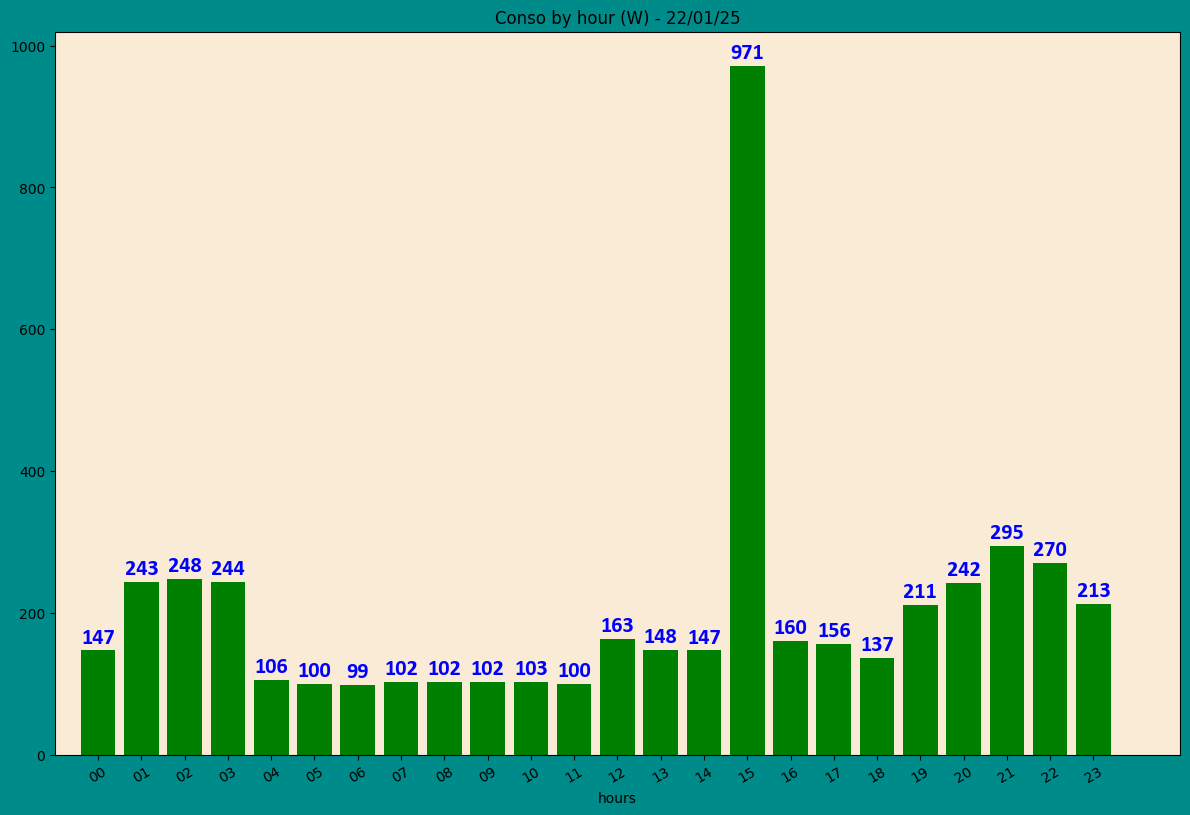

In [1149]:
day,conso_byhour(day)

In [1150]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


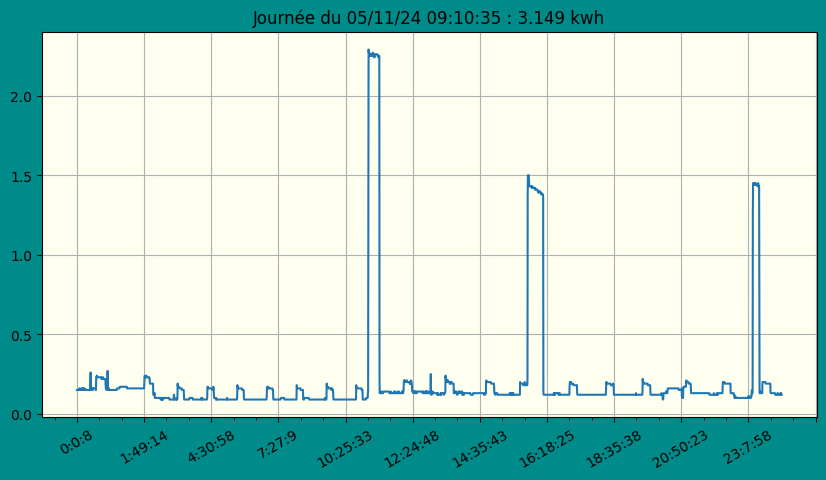

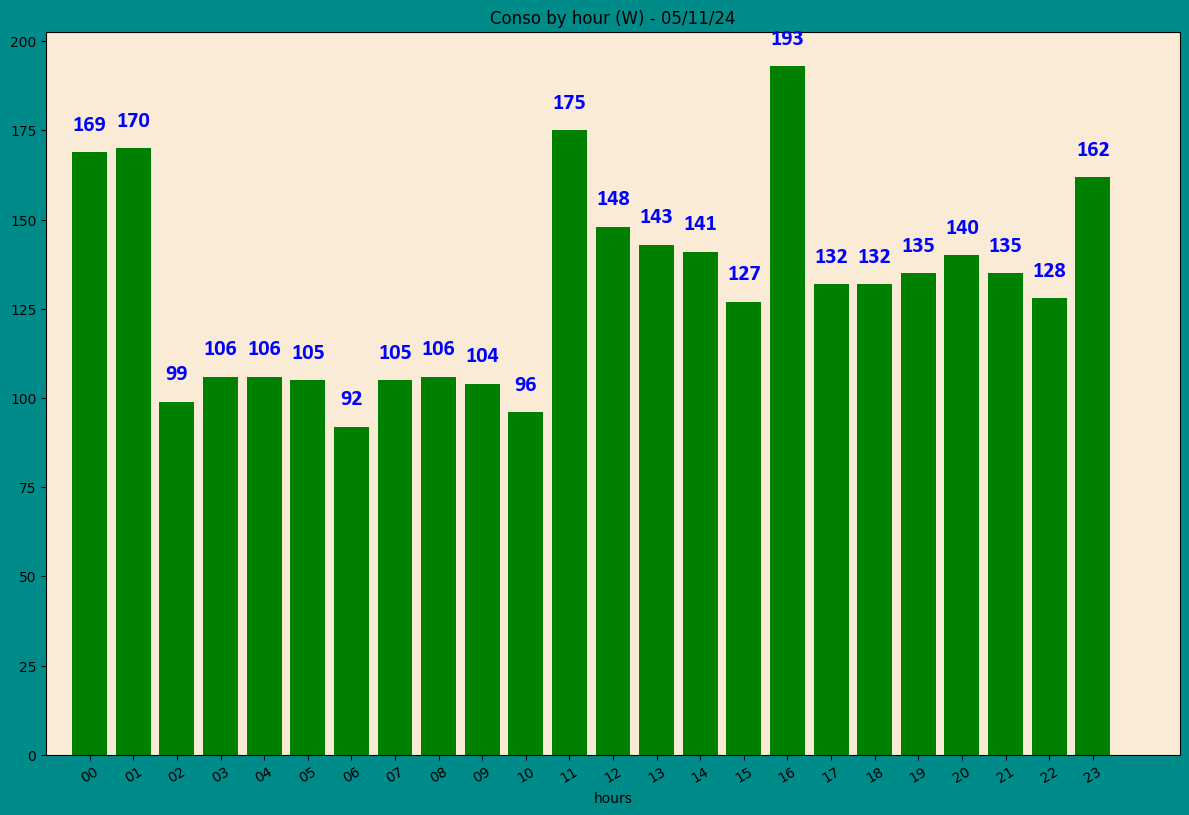

In [1151]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [1152]:
month

,day,hours,months,kWh
862047,01,00,2025-04,0.21
862048,01,00,2025-04,0.21
862049,01,00,2025-04,0.21
862050,01,00,2025-04,0.21
862051,01,00,2025-04,0.21
...,...,...,...,...
957806,30,23,2025-04,0.16
957807,30,23,2025-04,0.16
957808,30,23,2025-04,0.16
957809,30,23,2025-04,0.16


In [1153]:
month.describe()


,kWh
count,95764.000000
mean,0.310165
std,0.548094
min,0.080000
25%,0.090000
50%,0.120000
75%,0.180000
max,3.790000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

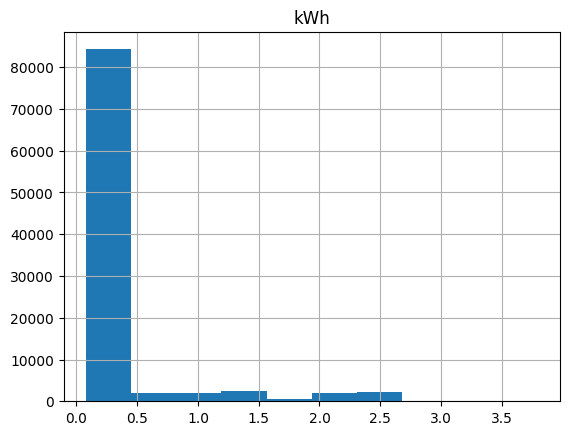

In [1154]:
month.hist()

<Axes: >

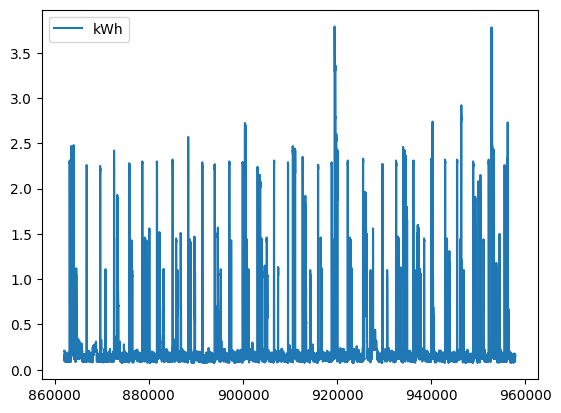

In [1155]:
month.plot()

In [1156]:
# index with max conso in this month
month.idxmax().kWh

np.int64(919453)

In [1157]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       954942
hours     865527
months    862047
kWh       919453
dtype: int64

In [1158]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [1159]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
17/07/24 16     264     264    NaN   NaN
         17     123     387 -141.0   NaN
         18     119     506   -4.0   NaN
         19     124     630    5.0   NaN
         20     117     747   -7.0   NaN
...             ...     ...    ...   ...
14/05/25 05      99     614   -2.0   6.0
         06      99     713    0.0   7.0
         07      96     809   -3.0   8.0
         08     100     909    4.0   9.0
         09      77     986  -23.0  10.0

[7218 rows x 4 columns]

In [1160]:
month

,day,hours,months,kWh
862047,01,00,2025-04,0.21
862048,01,00,2025-04,0.21
862049,01,00,2025-04,0.21
862050,01,00,2025-04,0.21
862051,01,00,2025-04,0.21
...,...,...,...,...
957806,30,23,2025-04,0.16
957807,30,23,2025-04,0.16
957808,30,23,2025-04,0.16
957809,30,23,2025-04,0.16


In [1161]:
month.idxmax()


day       954942
hours     865527
months    862047
kWh       919453
dtype: int64

In [1162]:
month.loc[month.idxmax().kWh]


day            19
hours          12
months    2025-04
kWh          3.79
Name: 919453, dtype: object

In [1163]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       170
          01       116
          02       113
          03       110
          04       110
          05        99
          06       111
          07       111
          08       109
          09        97
          10       173
          11       145
          12       147
          13       134
          14       201
          15       143
          16       153
          17       198
          18       147
          19       149
          20       141
          21       171
          22       226
          23       173
Name: kWh, dtype: int64

In [1164]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'22'

<Axes: xlabel='days,hours'>

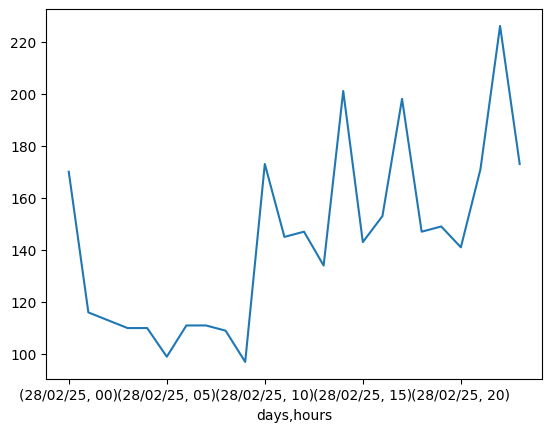

In [1165]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [1166]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [1167]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [1168]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [1169]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB